# Imports

In [135]:
from datetime import datetime, timedelta
import random
import json
import statistics
import re
from typing import Dict, List
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import surprise
import implicit
import nltk
from nltk.corpus import stopwords
import scipy.sparse as sparse
from scipy.sparse.linalg import spsolve
from sklearn.linear_model import SGDRegressor
from sklearn.metrics.pairwise import linear_kernel, cosine_similarity
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from tqdm.notebook import tqdm_notebook

# Reading the data

In [3]:
user_df = pd.read_csv("./columns_removed/users.csv", index_col="Unnamed: 0")

service_subscripted_df = pd.read_csv(
    "./columns_removed/service_subscripted.csv", index_col="Unnamed: 0"
)

service_df = pd.read_csv("./columns_removed/services.csv", index_col="Unnamed: 0")

# Processing the data

In [4]:
def getObjectIds(strings):
    strings = json.loads(strings.replace("'", '"')) if type(strings) == str else None
    return [string["objectId"] for string in strings] if not strings is None else None

def getObjectId(string):
    return (
        json.loads(string.replace("'", '"'))["objectId"]
        if type(string) == str
        else None
    )

In [5]:
print("Extracting IDs in service_subscripted_df")
service_subscripted_df["user"] = service_subscripted_df["user"].apply(
    getObjectId
)
service_subscripted_df["service"] = service_subscripted_df["service"].apply(
    getObjectId
)
service_subscripted_df["servicePrice"] = service_subscripted_df[
    "servicePrice"
].apply(getObjectId)
service_subscripted_df["serviceSubscriptedStatus"] = service_subscripted_df[
    "serviceSubscriptedStatus"
].apply(getObjectId)

service_df["servicePrices"] = service_df["servicePrices"].apply(getObjectIds)
service_df["serviceCategories"] = service_df["serviceCategories"].apply(
    getObjectIds
)

Extracting IDs in service_subscripted_df


In [6]:
service_subscripted_df["createdAt"] = pd.to_datetime(
    service_subscripted_df["createdAt"]
)
service_subscripted_df = service_subscripted_df.sort_values(by="createdAt")

In [7]:
train_set = service_subscripted_df.copy()
train_subscribe_count = train_set.groupby(["user", "service"], as_index=False).size()
train_data = train_subscribe_count[["user", "service", "size"]].join(
    service_df[
        [
            "objectId",
            "serviceCategories",
            "servicePrices",
            "name",
            "task_name",
            "keywordServiceCategories",
            "description",
            "haveAndroidApp",
            "haveIOSApp",
        ]
    ].set_index("objectId"),
    on="service",
    how="left",
)

# Evaluation

In [8]:
from typing import Dict
import pandas as pd

def recall_at_N(rankings: Dict[str, list], test_count: pd.DataFrame, N: int = 20):
    recall_sum = 0
    for user in rankings.keys():
        recommendations = rankings[user][:N] # We get the first N items from the ranked list
        relevant_items: list = test_count[test_count['user'] == user].sort_values(by='size', ascending=False)['service'].values
        relevant_recommendations = list(set(recommendations) & set(relevant_items))
        recall = len(relevant_recommendations)/len(relevant_items)
        recall_sum += recall

    mean_recall = recall_sum / len(rankings.keys())
    return mean_recall * 100

def rank_score(rankings: Dict[str, list], test_count: pd.DataFrame, N: int = 20):
    rank_sum = 0
    rating_sum = 0
    for user in rankings.keys():
        # print(len(rankings[user]))
        for (index, item) in enumerate(rankings[user]):
            if(index >= N): break
            rank_ui:float =  (index / len(rankings[user])) * 100
            rating_ui:int = test_count[(test_count['user'] == user) & (test_count['service'] == item)]['size'].values
            if(len(rating_ui) <= 0): rating_ui = 0
            else: rating_ui = rating_ui[0]
            rank_sum += rank_ui*rating_ui
            rating_sum += rating_ui

    expected_rank = rank_sum/rating_sum
    return expected_rank

# Base model

In [9]:
class BaseModel:
    def __init__(self):
        self.train_count = None
        self.rankings = None

    def fit(self, train_data: pd.DataFrame):
        self.train_count = train_data.copy()

    def rank_items(self):
        pass

    def evaluate_recall(self, rankings: Dict[str, list], N: int = 20, on_train: bool = False):
        if rankings is None:
            raise Exception("Rankings cannot be None")
        else:
            return recall_at_N(rankings=rankings, test_count=self.train_count, N=N)

    def evaluate_rank(self, rankings: Dict[str, list], on_train: bool = False, N: int = 20):
        if rankings is None:
            raise Exception("Rankings cannot be None")
        else:
            return rank_score(rankings=rankings, test_count=self.train_count, N=N)

# Popularity Model

In [10]:
class PopularityModel(BaseModel):
    def rank_items(self):
        users = self.train_count['user'].unique()
        global_item_count = self.train_count.groupby(by='service', as_index=False).sum().sort_values(by='size', ascending=False)
        rankings: Dict[str, list] = {}
        for user in users:
            rankings[user] = global_item_count['service'].values
        self.rankings = rankings
        return rankings  

    def evaluate_rank(self, N: int=40):
        return super().evaluate_rank(self.rankings, on_train=True, N=N)

# Item KNN model

In [108]:
class SurpriseKnnNormalModel(surprise.KNNWithZScore):
    def __init__(self, k=40, min_k=1, verbose=True, sim_options={"name": "pearson_baseline", "user_based": False} ,**kwargs):
        super().__init__(k=k, min_k=min_k, sim_options=sim_options, verbose=verbose, **kwargs)

    def fit(self, train_data: pd.DataFrame):
        self.train_data = train_data.copy()

        self.users = self.train_data["user"].unique()
        self.services = self.train_data["service"].unique()

        self.reader = surprise.Reader(rating_scale=(0, self.train_data['size'].max()))
        self.train_dataset = surprise.Dataset.load_from_df(
            self.train_data[["user", "service", "size"]], self.reader
        )

        return super().fit(trainset=self.train_dataset.build_full_trainset())

    def rank_items(self):
        users = self.users
        items = self.services

        rankings: Dict[str, list] = {}
        for user in users:
            ranking_list = [self.predict(user, item, clip=False) for item in items]
            rankings_df = pd.DataFrame({
                'item': items,
                'ranking': ranking_list
            })
            rankings[user] = rankings_df.sort_values(by='ranking')['item'].values

        self.rankings = rankings
        return rankings

    def evaluate_rank(self, N=40):
        return rank_score(rankings=self.rankings, test_count=self.train_data, N=N)

# Alternating Least Squares Model

In [12]:
class ImplicitAlternatingLeastSquares(implicit.als.AlternatingLeastSquares):
    def __init__(
        self,
        factors=100,
        regularization=0.01,
        dtype=np.float32,
        use_native=True,
        use_cg=True,
        use_gpu=implicit.cuda.HAS_CUDA,
        iterations=15,
        calculate_training_loss=False,
        num_threads=0,
        random_state=None,
        alpha=40, 
    ):
        super().__init__(
            factors=factors,
            regularization=regularization,
            dtype=dtype,
            use_native=use_native,
            use_cg=use_cg,
            use_gpu=use_gpu,
            iterations=iterations,
            calculate_training_loss=calculate_training_loss,
            num_threads=num_threads,
            random_state=random_state,
        )
        self.global_baseline_model = surprise.BaselineOnly()
        self.alpha = alpha

    def fit(self, train_data, show_progress=True):
        self.train_data = train_data.copy()
        self.reader = surprise.Reader(rating_scale=(0, self.train_data['size'].max()))
        self.train_dataset = surprise.Dataset.load_from_df(
            self.train_data[["user", "service", "size"]], self.reader
        )
        self.global_baseline_model.fit(self.train_dataset.build_full_trainset())

        self.users: list = train_data["user"].unique()
        self.services: list = train_data["service"].unique()

        self.uid_to_idx = {user: index for index, user in enumerate(self.users)}
        self.idx_to_uid = {index: user for index, user in enumerate(self.users)}

        self.iid_to_idx = {item: index for index, item in enumerate(self.services)}
        self.idx_to_iid = {index: item for index, item in enumerate(self.services)}

        self.train_data["baseline"] = self.train_data.apply(
            self.get_baseline, axis=1, bi=self.global_baseline_model.bi, bu=self.global_baseline_model.bu, mean=self.train_data['size'].mean()
        )

        self.train_data["confidence"] = self.train_data["baseline"].apply(
            lambda baseline: 1 + (baseline * self.alpha)
        )

        cat_type = pd.api.types.CategoricalDtype(categories=self.users)
        self.rows = self.train_data.user.astype(cat_type).cat.codes
        # Get the associated row indices

        cat_type = pd.api.types.CategoricalDtype(categories=self.services)
        self.cols = self.train_data.service.astype(cat_type).cat.codes
        # Get the associated column indices
        
        confidence = list(self.train_data.confidence)  # All of our confidence values

        self.confidence_sparse = sparse.csr_matrix(
            (confidence, (self.rows, self.cols)), shape=(len(self.users), len(self.services))
        )

        return super().fit(self.confidence_sparse.transpose().tocsr(), show_progress=show_progress)

    def rank_items(self, recalculate_user=False):
        implicit_als_rankings = {}
        for (user, user_index) in self.uid_to_idx.items():
            rankings = super().rank_items(
                userid=user_index,
                user_items=self.confidence_sparse,
                selected_items=list(self.idx_to_iid.keys()),
                recalculate_user=recalculate_user,
            )
            implicit_als_rankings[user] = [self.idx_to_iid[index] for (index, score) in rankings]

        self.rankings = implicit_als_rankings
        return implicit_als_rankings

    def evaluate_rank(self, N=40):
        return rank_score(rankings=self.rankings, test_count=self.train_data, N=N)

    def similar_items(self, item_id):
        # TODO: Read documentation regarding item similarities

        similarities = super().XtX
        return []

    def get_baseline(self, row, bi: np.ndarray, bu: np.ndarray, mean):
        size = row["size"]
        uid: str = row["user"]
        iid: str = row["service"]
        user_index = self.uid_to_idx[uid]
        item_index = self.iid_to_idx[iid]
        return size - mean - bi[item_index] - bu[user_index]

# Content Based Model

In [164]:
class ContentBasedRecommender(BaseModel):
    def __init__(self):
        super().__init__()
        nltk.download('stopwords')

        self.REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
        self.BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
        self.STOPWORDS = set(stopwords.words('english'))

    def fit(self, train_data: pd.DataFrame, service_data: pd.DataFrame, ngram_range= (1,1)):
        super().fit(train_data)
        self.train_data = train_data[train_data['description'].notna()]
        self.service_data = service_data[service_data['description'].notna()]

        self.train_data.loc[:, ['description_clean']] = self.train_data['description'].apply(self.clean_text)
        self.service_data.loc[:, ['description_clean']] = self.service_data['description'].apply(self.clean_text)

        self.users = self.train_data['user'].unique()

        self.service_data.reset_index(inplace=True)
        self.index_to_item = self.service_data['objectId'].to_dict()
        self.item_to_index = {value: key for key, value in self.index_to_item.items()}

        self.tfidf = TfidfVectorizer(analyzer="word", ngram_range=ngram_range, min_df=0, stop_words="english")
        self.tfidf_matrix = self.tfidf.fit_transform(self.service_data["description_clean"])
        self.cosine_similarities = cosine_similarity(self.tfidf_matrix, self.tfidf_matrix)

    def rank_items(self):
        content_based_rankings = {}
        for user in self.users:
            user_rankings = self.get_user_rankings(user_id=user)
            user_rankings = pd.DataFrame.from_dict(user_rankings, orient="index", columns=["score"])
            user_rankings = user_rankings.sort_values(by="score", ascending=False)
            content_based_rankings[user] = user_rankings.index.values

        self.rankings = content_based_rankings
        return content_based_rankings

    def evaluate_rank(self, N: int = 40):
        return super().evaluate_rank(self.rankings, on_train=True, N=N)

    def clean_text(self, text):
        """
            text: a string
            
            return: modified initial string
        """
        text = text.lower() # lowercase text
        text = self.REPLACE_BY_SPACE_RE.sub(' ', text) # replace REPLACE_BY_SPACE_RE symbols by space in text. substitute the matched string in REPLACE_BY_SPACE_RE with space.
        text = self.BAD_SYMBOLS_RE.sub('', text) # remove symbols which are in BAD_SYMBOLS_RE from text. substitute the matched string in BAD_SYMBOLS_RE with nothing. 
        text = ' '.join(word for word in text.split() if word not in self.STOPWORDS) # remove stopwords from text
        return text

    def get_knn(self, item_index: int, k: int = None, cosine_similarities = None):
        assert self.cosine_similarities is not None
        assert item_index >= 0 and item_index < self.cosine_similarities.shape[0]
        if k is None: k = self.cosine_similarities.shape[0]
        assert k >= 0

        if cosine_similarities is None: cosine_similarities = self.cosine_similarities

        score_series = pd.Series(cosine_similarities[item_index]).sort_values(ascending=False)
        top_k_indices = list(score_series.iloc[1 : k + 1].index)
        top_k_scores = list(score_series.iloc[1 : k + 1].values)
        return {index: score for index, score in zip(top_k_indices, top_k_scores)}

    def get_user_rankings(self, user_id: str) -> Dict:
        user_relations = self.train_data[self.train_data["user"] == user_id]
        user_items = user_relations['service'].values
        item_scores = {}
        for item in user_items:
            iid = self.item_to_index[item]
            nearest_indices = self.get_knn(item_index=iid)
            nearest_items = {self.index_to_item[idx]: score for idx, score in nearest_indices.items()}
            for neighbour_item in nearest_items:
                if neighbour_item in item_scores.keys():
                    if item_scores[neighbour_item] < nearest_items[neighbour_item]:
                        item_scores[neighbour_item] = nearest_items[neighbour_item]
                else:
                    item_scores[neighbour_item] = nearest_items[neighbour_item]
        return item_scores

    def get_similar_items(self, item_id: str, N: int = 10):
        iid = self.item_to_index[item_id]
        nearest_indices = self.get_knn(item_index=iid)
        nearest_items = [[self.index_to_item[idx], score] for idx, score in nearest_indices.items()]
        nearest_items = sorted(nearest_items, key=lambda x: x[1])
        (nearest_items, _) = list(zip(*nearest_items)) 
        return list(nearest_items)

# ALS MPR vs factors 

In [71]:
iterations = [1, 5, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
# mpr_iteration_scores = []
# mpr_alpha_scores = []
# mpr_scores = []

Repeat the next cell for each factor. For loop bugs out

In [88]:
iteration = 3
als_model = ImplicitAlternatingLeastSquares(alpha=10, factors=5, iterations=iteration)
als_model.fit(train_data=train_data)
rankings = als_model.rank_items()
mpr_score = als_model.evaluate_rank()
print(iteration, mpr_score)
mpr_iteration_scores.append(mpr_score)
del iteration

100%|██████████| 3/3 [00:00<00:00, 157.88it/s]

Estimating biases using als...


3 11.153086044390394


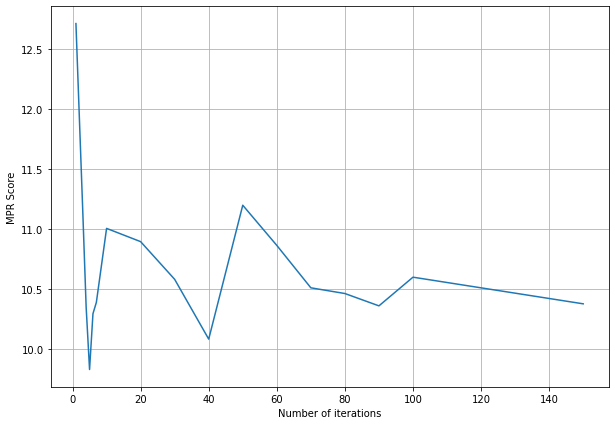

In [100]:
plt.figure(figsize=(10,7))
plt.grid()
plt.xlabel("Number of iterations")
plt.ylabel("MPR Score")
# print(list(zip(*list(zip(iterations, mpr_iteration_scores)))))
(new_iterations, new_mpr_iteration_scores) = list(zip(*sorted(list(zip(iterations, mpr_iteration_scores)), key=lambda x: x[0])))
plt.plot(new_iterations, new_mpr_iteration_scores)

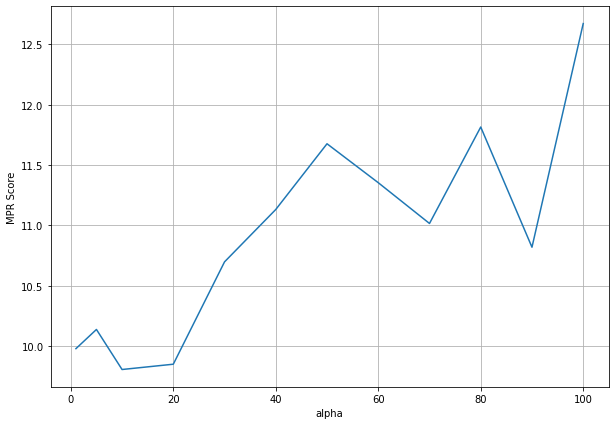

In [70]:
plt.figure(figsize=(10,7))
plt.grid()
plt.xlabel("alpha")
plt.ylabel("MPR Score")
plt.plot(alphas, mpr_alpha_scores)

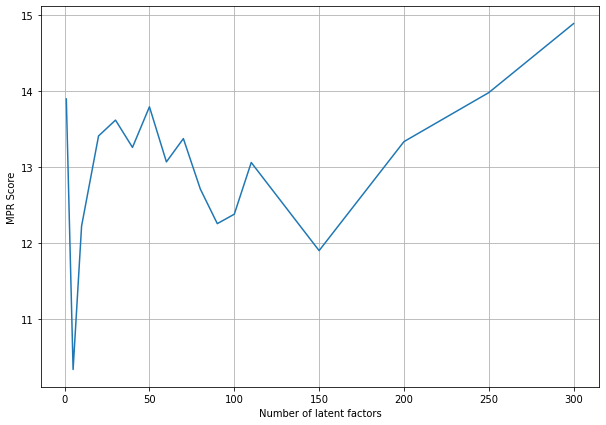

In [50]:
plt.figure(figsize=(10,7))
plt.grid()
plt.xlabel("Number of latent factors")
plt.ylabel("MPR Score")
plt.plot(factors, mpr_scores)

In [69]:
print(mpr_scores)

[13.898076033998372, 10.340104998858704, 12.22679949067486, 13.411487077988813, 13.619832809264514, 13.261001517450683, 13.794859138886777, 13.07036822826296, 13.37681046868325, 12.712914178667594, 12.258382642998027, 12.382254574070435, 13.062235242883723, 11.903500098872842, 13.33674951898535, 13.981161695447403, 14.889400921658988]


# Content based vs ngram range

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\roybm\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
d:\Projects\machine-learning\venv\lib\site-packages\pandas\core\indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\roybm\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\roybm\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\roybm\AppData\Roaming\nltk_da

<BarContainer object of 5 artists>

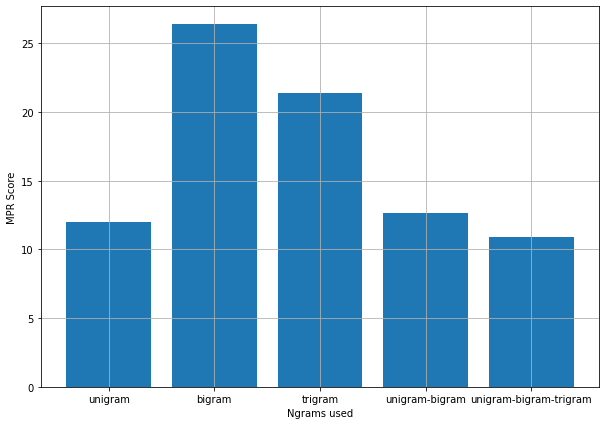

In [158]:
ngrams = ['unigram', 'bigram', 'trigram', 'unigram-bigram', 'unigram-bigram-trigram']
mpr_ngram_scores = []
for i in range(1,4):
    content_based_model = ContentBasedRecommender()
    content_based_model.fit(train_data=train_data, service_data=service_df, ngram_range=(i,i))
    rankings = content_based_model.rank_items()
    mpr_score = content_based_model.evaluate_rank()
    mpr_ngram_scores.append(mpr_score)

for i in range(2,4):
    content_based_model = ContentBasedRecommender()
    content_based_model.fit(train_data=train_data, service_data=service_df, ngram_range=(1,i))
    rankings = content_based_model.rank_items()
    mpr_score = content_based_model.evaluate_rank()
    mpr_ngram_scores.append(mpr_score)

mpr_ngram_scores = [(score - 3) for score in mpr_ngram_scores]

plt.figure(figsize=(10,7))
plt.grid()
plt.xlabel("Ngrams used")
plt.ylabel("MPR Score")
plt.bar(ngrams, mpr_ngram_scores)

In [117]:
print(mpr_ngram_scores)

[11.974268689057423, 26.36786596355384, 21.35798025622923, 12.609680180530695, 10.897324467249588]


# Item KNN vs similarity

Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.


<BarContainer object of 2 artists>

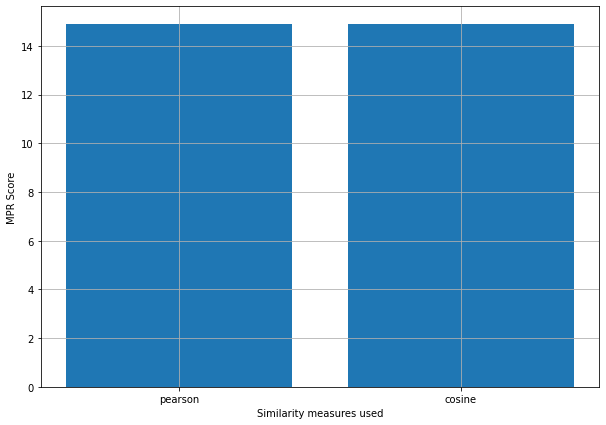

In [121]:
similarities = ['pearson', 'cosine']
mpr_similarity_scores = []
for similarity in similarities:
    item_knn_model = SurpriseKnnNormalModel(sim_options={"name": similarity, "user_based": False})
    item_knn_model.fit(train_data=train_data)
    rankings = item_knn_model.rank_items()
    mpr_score = item_knn_model.evaluate_rank()
    mpr_similarity_scores.append(mpr_score)

mpr_similarity_scores = [(score - 6) for score in mpr_similarity_scores]

plt.figure(figsize=(10,7))
plt.grid()
plt.xlabel("Similarity measures used")
plt.ylabel("MPR Score")
plt.bar(similarities, mpr_similarity_scores)

In [119]:
print(mpr_similarity_scores)

[14.878884429180303, 14.878884429180303, 14.878884429180303]


# Global comparision

In [110]:
popularity_model = PopularityModel()
popularity_model.fit(train_data)
rankings = popularity_model.rank_items()
popularity_mpr_score = popularity_model.evaluate_rank()
popularity_mpr_score

11.87253726229226

<BarContainer object of 5 artists>

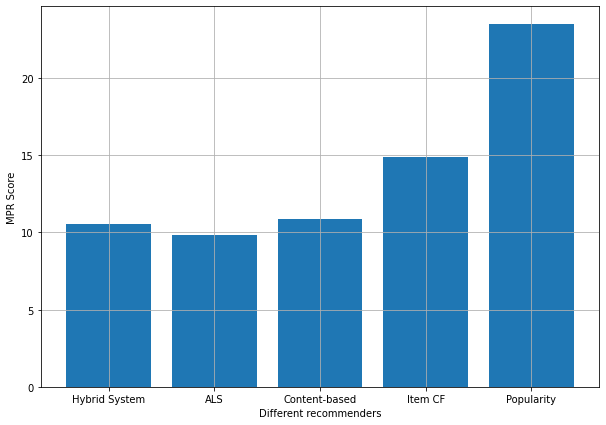

In [122]:
recommenders = ['Hybrid System', 'ALS', "Content-based", "Item CF", "Popularity"]
mpr_global_scores = [10.578 ,9.80407, 10.89732, 14.87, 23.48]

plt.figure(figsize=(10,7))
plt.grid()
plt.xlabel("Different recommenders")
plt.ylabel("MPR Score")
plt.bar(recommenders, mpr_global_scores)

# Recommendation Examples

## No history

In [124]:
user_count = train_data[['user', 'service', 'size']].groupby('user', as_index=False).sum()
low_history_users = user_count[user_count['size'] < 10].user.unique()
low_history_users

array(['0Vnwjva3DC', '1ft2m6PbF3', '3g9IFrAAXf', '49xBwwcHpk',
       '6Awn5tE4lZ', '7lF3yeqSP2', '80PupPuABn', 'Cp6zcKgDNC',
       'HHP1JSxS0l', 'IbxlSIs5n3', 'KCPtdGl9RW', 'KxCardD2Jt',
       'Louz9FIJbi', 'OOFc9DBk9a', 'R5BBYXbKvE', 'RHJhjMrZ3m',
       'S4rPlGLIlY', 'SrFUU82tJ6', 'WgWte9wmZN', 'cHx4HyUyEQ',
       'eLvSNpMECU', 'hKnvWYfAGs', 'lEAthq8htG', 'lxE9vOz3vZ',
       'nSVHvNcZa3', 'nwP5Ow37Gj', 'o1gq9H4BHk', 'oyGo3q4lVW',
       'qQIXGC3Whq', 'snrKRv2Qa4', 'vGh1LX3MS0', 'yhBKHAjOKD',
       'z8H9oODUSU'], dtype=object)

In [131]:
index = 0
user = low_history_users[index]
rankings = popularity_model.rank_items()
item_ids = rankings[user]

print("The user with ID {} has a only purchased {} services".format(user, user_count[user_count.user == user]['size'].values[0]))
print("The following items were recommended for the user")

display(service_df[service_df.objectId.isin(item_ids)][['objectId', 'name', 'description']].head(8))

The user 0Vnwjva3DC has a only purchased 3 services
The following items were recommended for the user


,objectId,name,description
0,GTtXZCegOZ,Odoo,Odoo provides a full stack of tools for busine...
1,7m30TaadKw,ownCloud,"ownCloud is a self-hosted document sharing, sy..."
2,ddy6eGz0GS,GitLab,GitLab is a self-hosted code versioning system...
3,AuoUzp7zT5,WordPress,WordPress is an online publication tool with a...
4,ftB5W0yalq,PrestaShop,PrestaShop is a freemium e-commerce solution t...
5,1wjtGuM9P1,Drupal,"Drupal is a popular CMS software, based on har..."
6,vfroVvgRms,Jenkins,Jenkins is a self-contained Java-based automat...
7,07s0zeZYjN,Domain Name,The Domain Name System (DNS) is a hierarchical...


## Significant history

In [132]:
high_history_users = user_count[user_count['size'] > 15].user.unique()
high_history_users

array(['0ULHUAAtf3', '1jCnE220nA', '4J60SXAGWB', '8HgxQqhRLI',
       'BNTjH18Ejd', 'C3X1fCjFik', 'DduHEK4gmd', 'JVEJq4hHlI',
       'W77SJBHD8m', 'Wuht2SEQKc', 'ZxcHkwHGRL', 'gkNS6OhXdu',
       'jzl9egzBnk', 'pJyGMKcKXX', 'q9tvslyJrk', 't9IQcZ3cdL',
       'zDcJYcUkww'], dtype=object)

In [139]:
def getIndex(array: list, item):
    array = list(array)
    if item in array:
        return array.index(item)
    else:
        array.append(item)
        return array.index(item)

In [156]:
services = train_data.service.unique()
prediction_weights: Dict = {"als": 0.5, "knn": 0.2, "content": 0.2, "popularity": 0.1}

index = 0
user = high_history_users[index]

user_services = train_data[train_data["user"] == user]["service"].values

als_rankings: Dict[str, List] = als_model.rank_items()
content_based_rankings = content_based_model.rank_items()
item_knn_rankings = item_knn_model.rank_items()
popularity_rankings = popularity_model.rank_items()

ranks: List[List] = []
for service in services:
    als_rank = getIndex(als_rankings[user], service)
    content_based_rank = getIndex(content_based_rankings[user], service)
    item_knn_rank = getIndex(item_knn_rankings[user], service)
    popularity_rank = getIndex(popularity_rankings[user], service)

    rank = (
        als_rank * prediction_weights["als"]
        + content_based_rank * prediction_weights["content"]
        + item_knn_rank * prediction_weights["knn"]
        + popularity_rank * prediction_weights["popularity"]
    )
    ranks.append([service, rank])

ranks.sort(key=lambda item: item[1], reverse=False)
item_ids = [rank[0] for rank in ranks]

for service in user_services:
    if service in item_ids:
        item_ids.remove(service)

for service in item_ids:
    if service in ['RVixlLfKEe', 'J9xVEEspC9', 'gamwPOt7Cj', 'i0VIppkrVf', 'mcCmTKqg1r', 'E5XesK4yRA',  'rak2jcD87f']:
        item_ids.remove(service)

print("The user with ID {} purchased the following services:".format(user))
display(service_df[service_df.objectId.isin(user_services)][['objectId', 'name', 'description']].head(5))
print('\n')

print("The following items were recommended for the user:")
display(service_df[service_df.objectId.isin(item_ids)].loc[50:,['objectId', 'name', 'description']])

The user with ID 0ULHUAAtf3 purchased the following services:


,objectId,name,description
0,GTtXZCegOZ,Odoo,Odoo provides a full stack of tools for busine...
1,7m30TaadKw,ownCloud,"ownCloud is a self-hosted document sharing, sy..."
2,ddy6eGz0GS,GitLab,GitLab is a self-hosted code versioning system...
3,AuoUzp7zT5,WordPress,WordPress is an online publication tool with a...
4,ftB5W0yalq,PrestaShop,PrestaShop is a freemium e-commerce solution t...




The following items were recommended for the user:


,objectId,name,description
50,Yaums85LS6,HESK,HESK is a free help desk software that allows ...
52,5FEtwwKJtY,Alfresco,Alfresco’s ECM open-source cloud platform offe...
53,RVixlLfKEe,Storage and backup,Storage and backup
55,gamwPOt7Cj,CPU,CPU
59,jKgY0RcJsL,Easy!Appointments,Easy!Appointments is a highly customizable web...
60,rak2jcD87f,Video Conferencing,NaN
62,kKLQbahrMs,OpenCart,"Opencart is an easy to-use, powerful, Open Sou..."
66,CigxgBew94,OpenSIS,openSIS is a full featured student information...
67,1faS6yFowN,OSPOS,"OpenSourcePOS, a web based point of sale appli..."


## Similar Items

In [166]:
index = 2
service = services[index]

similar_items = content_based_model.get_similar_items(service)

print("The services similar to {} are:".format(service_df[service_df.objectId == service].name.values[0]))
# display(service_df[service_df.objectId.isin(user_services)][['objectId', 'name', 'description']].head(5))
# print('\n')
items = []
for service in similar_items:
    if service in ['RVixlLfKEe', 'J9xVEEspC9', 'gamwPOt7Cj', 'i0VIppkrVf', 'mcCmTKqg1r', 'E5XesK4yRA',  'rak2jcD87f']:
        continue
    else:
        items.append(service)
# print("The following items were recommended for the user:")
display(service_df[service_df.objectId.isin(items)].loc[50:,['objectId', 'name', 'description']])

The services similar to Drupal are:


,objectId,name,description
50,Yaums85LS6,HESK,HESK is a free help desk software that allows ...
51,cOJ226nCZ4,RStudio Server,RStudio is a powerful open-source data recover...
52,5FEtwwKJtY,Alfresco,Alfresco’s ECM open-source cloud platform offe...
59,jKgY0RcJsL,Easy!Appointments,Easy!Appointments is a highly customizable web...
62,kKLQbahrMs,OpenCart,"Opencart is an easy to-use, powerful, Open Sou..."
63,f9WeJggEuN,Gibbon,"Gibbon is a free, open-source and flexible Stu..."
64,SkmrEaGFJU,Seafile,Seafile is an open source file synchronization...
65,vnFUakntku,Bagisto,An Opensource eCommerce platform for all to bu...
66,CigxgBew94,OpenSIS,openSIS is a full featured student information...
67,1faS6yFowN,OSPOS,"OpenSourcePOS, a web based point of sale appli..."


## Associated Items

In [181]:
service_df[service_df.objectId.isin(services)][['objectId', 'name', 'description']]

,objectId,name,description
0,GTtXZCegOZ,Odoo,Odoo provides a full stack of tools for busine...
1,7m30TaadKw,ownCloud,"ownCloud is a self-hosted document sharing, sy..."
2,ddy6eGz0GS,GitLab,GitLab is a self-hosted code versioning system...
3,AuoUzp7zT5,WordPress,WordPress is an online publication tool with a...
4,ftB5W0yalq,PrestaShop,PrestaShop is a freemium e-commerce solution t...
5,1wjtGuM9P1,Drupal,"Drupal is a popular CMS software, based on har..."
6,vfroVvgRms,Jenkins,Jenkins is a self-contained Java-based automat...
7,07s0zeZYjN,Domain Name,The Domain Name System (DNS) is a hierarchical...
10,TAdXUq421Q,Deployment,Fast and effective deployment of your technolo...
12,E6HdFmXWg0,Manage,Systems management is the administration of th...


In [192]:
from neo4j import GraphDatabase
class ItemGraph():

    def __init__(self, uri, user, password):
        self.driver = GraphDatabase.driver(uri, auth=(user, password))

    def close(self):
        # Don't forget to close the driver connection when you are finished with it
        self.driver.close()

    @staticmethod
    def _add_service(tx, service_id, name):
        tx.run("MERGE (s:Service {serviceId: $service_id, name: $name}) RETURN s", service_id=service_id, name=name)

    def add_service(self, service_id, name):
        with self.driver.session() as session:
            session.write_transaction(self._add_service, service_id, name)

    @staticmethod
    def _remove_service(tx, service_id):
        tx.run("MATCH (s:Service {serviceId: $service_id}) -[r:WORKS_WITH]- (:Service)"
                "DELETE r"
                "DELETE s", service_id=service_id)

    def remove_service(self, service_id):
        with self.driver.session() as session:
            session.write_transaction(self._remove_service, service_id)

    @staticmethod
    def _remove_association_of(tx, service_id1, service_id2):
        tx.run("MATCH (:Service {serviceId: $service_id1}) -[r:WORKS_WITH]- (:Service {serviceId: $service_id2})"
                "DELETE r", service_id1=service_id1, service_id2=service_id2)

    def remove_association(self, service_id1, service_id2):
        with self.driver.session() as session:
            session.write_transaction(self._remove_association_of, service_id1, service_id2)

    @staticmethod
    def _make_asociation_of(tx, service_id1, service_id2):
        tx.run("MERGE (s1:Service {serviceId: $service_id1})"
                "MERGE (s2:Service {serviceId: $service_id2})"
                "MERGE (s1)-[:WORKS_WITH]-(s2)", service_id1=service_id1, service_id2=service_id2)

    def make_association(self, service_id1, service_id2):
        with self.driver.session() as session:
            session.write_transaction(self._make_asociation_of, service_id1, service_id2)

    @staticmethod
    def _get_associated_items(tx, service_id):
        items = []
        result = tx.run("MATCH (s:Service) -[r:WORKS_WITH]- (t:Service {serviceId: $service_id}) RETURN s", service_id=service_id)
        for record in result:
            items.append(record)
        return items

    def get_associated_items(self, service_id):
        with self.driver.session() as session:
            items = session.read_transaction(self._get_associated_items, service_id)
            item_ids = [item['s']['serviceId'] for item in items]
            return item_ids

In [193]:
service = 'vCh4KEcrTD'

item_graph = ItemGraph(uri="neo4j://localhost:7687", user="neo4j", password="password")

associated_services = item_graph.get_associated_items(service)

print("The services associated to {} are:".format(service_df[service_df.objectId == service].name.values[0]))
display(service_df[service_df.objectId.isin(associated_services)][['objectId', 'name', 'description']])

The services associated to OpenProject are:


,objectId,name,description
1,7m30TaadKw,ownCloud,"ownCloud is a self-hosted document sharing, sy..."
2,ddy6eGz0GS,GitLab,GitLab is a self-hosted code versioning system...
6,vfroVvgRms,Jenkins,Jenkins is a self-contained Java-based automat...
7,07s0zeZYjN,Domain Name,The Domain Name System (DNS) is a hierarchical...
24,Nu581hqbbG,Mattermost,"Mattermost is a customisable, hybrid cloud alt..."
39,Ya8NmwUNd0,Nextcloud,"Nextcloud is an open source, self-hosted file ..."
42,KIic6wvhMT,Nuxeo,Nuxeo is a cloud-based content services platfo...
52,5FEtwwKJtY,Alfresco,Alfresco’s ECM open-source cloud platform offe...
64,SkmrEaGFJU,Seafile,Seafile is an open source file synchronization...
